## Bayesian Statistic dengan PyMC3

Import segala yang diperlukan:

In [1]:
%matplotlib inline

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

# from astropy.visualization import astropy_mpl_style # plot yang lebih bagus
# plt.style.use(astropy_mpl_style)

# plt.rcParams['figure.figsize'] = (16,10) # ukuran gambar diperbesar
plt.rcParams['font.size'] = 16

Nyatakan nilai benar dari parameter yang ada. Persamaan yang ingin dinyatakan adalah persamaan linier yang memenuhi $y = \alpha + \beta_0 X_1 + \beta_1 X_2 + \sigma $

In [48]:
# random number generator

np.random.seed(123)

In [49]:
# True parameter values

alpha, sigma = 1, 1
beta = [1, 2.5]

# size of dataset

size = 100

# predictor variable

X1 = np.linspace(0, 1, size )
X2 = np.linspace(0, .8, size)

In [50]:
# simulate outcome variables

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


(-2, 2)

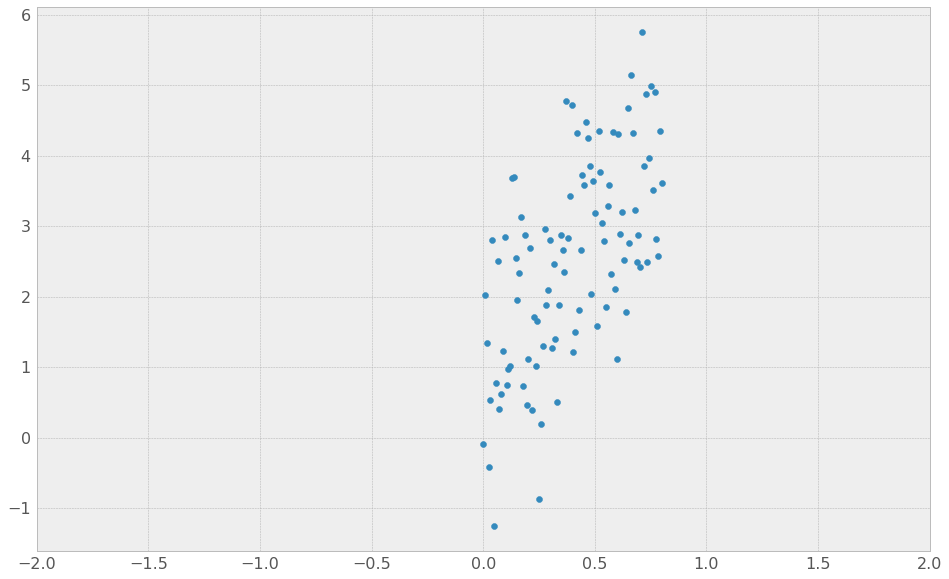

In [51]:
plt.scatter(X2, Y)
plt.xlim(-2,2)

Mendefinisikan model:

In [52]:
# specifying model

from pymc3 import Model, Normal, HalfNormal

basic_model = Model() # kontainer dari model, bisa juga langsung ditulis dengan "with Model() as basic_model: " untuk hemat baris

# context manager syntax
with basic_model:
    # priors for unknown
    alpha = Normal('alpha', mu = 0., sd = 10.)
    beta = Normal('beta', mu = 0., sd = 10., shape = 2)
    sigma = HalfNormal('sigma', sd = 1.)
    
    # expected values of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # likelihood of observations
    Y_obs = Normal('Y_obs', mu = mu, sd = sigma, observed = Y)

### Metode MAP untuk mencari perkiraan nilai parameter

Penentuan nilai *fitting* dengan metode MAP (*maximum a posteriori*). Kelebihan: cepat. Kelemahan: bisa *misleading* kalau modus data tidak merepresentasikan distribusi. 

In [53]:
from pymc3 import find_MAP # menggunakan algoritma optimisasi BFGS (Broyden-Fletcher-Goldfarb-Shanno)

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

logp = -167.38, ||grad|| = 7.283: 100%|██████████████████████████████████████████████| 19/19 [00:00<00:00, 2376.23it/s]


{'alpha': array(1.01393636), 'beta': array([1.84518655, 1.47614924]), 'sigma_log__': array(0.11439412), 'sigma': array(1.12119392)}


Masih penentuan nilai awal dengan MAP, tapi menggunakan algoritma optimisasi yang berbeda. Kali ini menggunakan Powell's method yang terangkum dalam `scipy.optimize`

In [54]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, method="L-BFGS-B") # Powell's method
# map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell) # Powell's method; deprecated

print(map_estimate)

logp = -167.38, ||grad|| = 7.283: 100%|██████████████████████████████████████████████| 19/19 [00:00<00:00, 2716.06it/s]


{'alpha': array(1.01393636), 'beta': array([1.84518655, 1.47614924]), 'sigma_log__': array(0.11439412), 'sigma': array(1.12119392)}


### Metode sampling untuk mencari perkiraan nilai parameter

Intinya menggunakan algoritma MCMC untuk sampling. Algoritma *sampler* yang didukung: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, dan `BinaryMetropolis`. Pelaksanaan *sampling* harus dilakukan di dalam kontainer (*model context*), dalam hal ini adalah `basic_model`.

In [55]:
from pymc3 import NUTS, sample, Metropolis

with basic_model:
    # obtain starting values via MAP
#     start = find_MAP(fmin=optimize.fmin_powell) # MAP method untuk nilai awal; deprecated

    start = find_MAP(method="L-BFGS-B") # MAP method untuk nilai awal
    
    # instantiate sampler
    step = NUTS(scaling=start)
#     step = Metropolis(tune_interval=2000)
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start)

logp = -167.38, ||grad|| = 7.283: 100%|██████████████████████████████████████████████| 19/19 [00:00<00:00, 2376.23it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
The number of effective samples is smaller than 25% for some parameters.


In [56]:
# with basic_model:
#     # obtain starting values via MAP
#     start = find_MAP(fmin=optimize.fmin_powell) # MAP method untuk nilai awal
    
#     # instantiate sampler
#     step = NUTS(scaling=start)
#     trace = sample(100, step, progressbar=False) # ambil 100 sampel sebagai 'burn in'
    
#     # draw 2000 posterior samples; mulai dari posisi sampel terakhir yang diambil
#     step = NUTS(scaling=trace[-1], gamma=.25)
#     trace = sample(2000, step, start=trace[-1], njobs=2)

`trace` berisi sampel yang dikumpulkan, urut sesuai dengan waktu ditemukannya. Bentuk dari `trace` adalah serupa dengan `numpy.arrays` sehingga bisa dipanggil sesuai indeks-nya. Misal: ambil 5 nilai terakhir dari variabel `alpha`:

In [57]:
trace['alpha'][-5:]

array([0.99343545, 0.85687925, 1.11698605, 0.79785338, 1.10914673])

### Analisis posterior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E0CEFF940>,
      dtype=object)

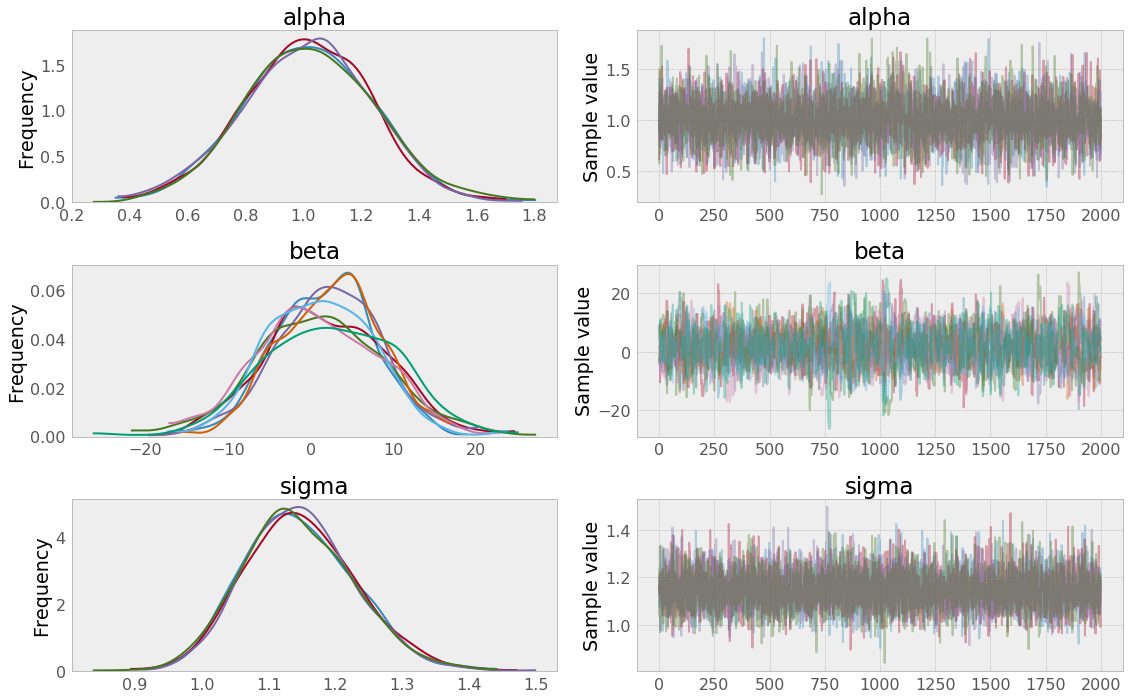

In [58]:
from pymc3 import traceplot
traceplot(trace, figsize = (16,10))

Tabulasi hasil juga bisa ditampilkan. Parameter yang ditampilkan juga bisa dipilih:

In [59]:
from pymc3 import summary
summary(trace, ['alpha','beta','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.013807,0.221893,0.003299,0.558415,1.426266,5052.131387,1.000158
beta__0,1.770749,6.134246,0.172297,-10.587459,13.226642,912.387431,1.003745
beta__1,1.568996,7.667713,0.215521,-13.329184,16.407576,908.034169,1.003590
sigma,1.145023,0.081183,0.001023,0.984496,1.297986,7688.873625,1.000140


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E163844E0>,
      dtype=object)

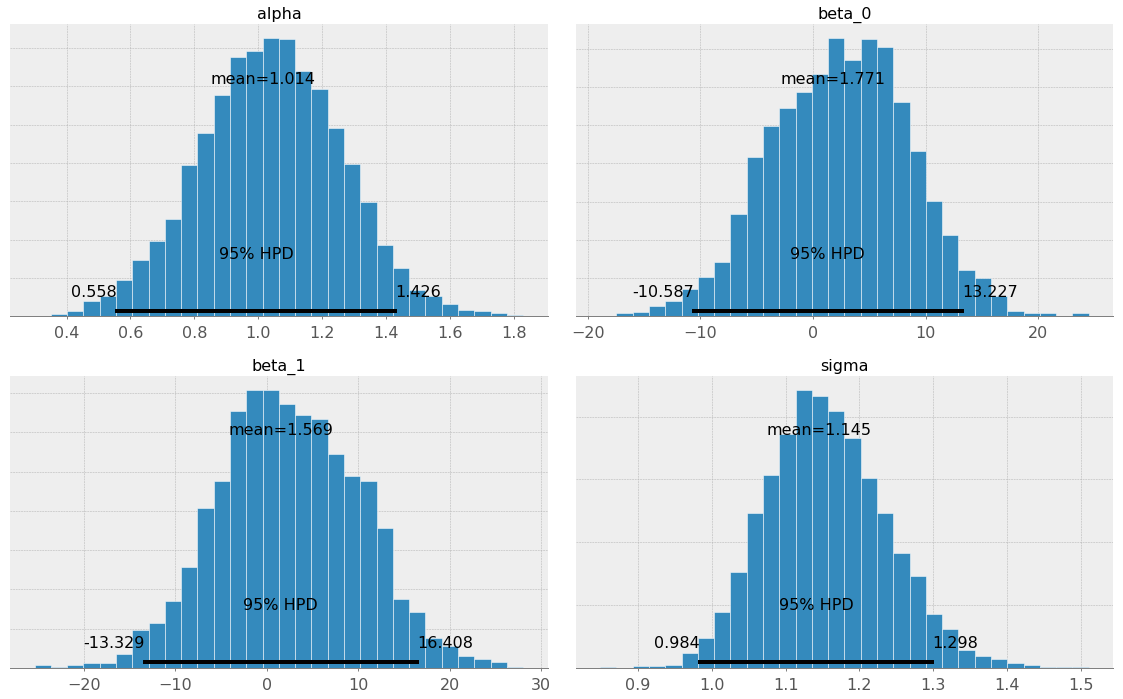

In [60]:
from pymc3 import plot_posterior
plot_posterior(trace, varnames=None, figsize = (16,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E12757710>,
      dtype=object)

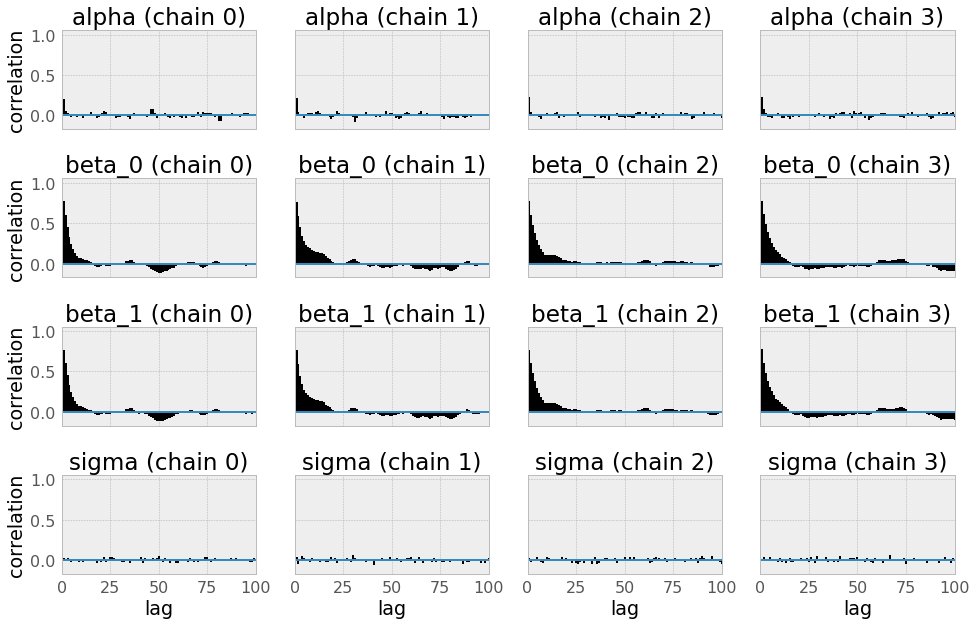

In [61]:
from pymc3 import autocorrplot
autocorrplot(trace, figsize = (16,10))

In [62]:
# from pymc3 import densityplot
# densityplot(trace, figsize = (16,10))

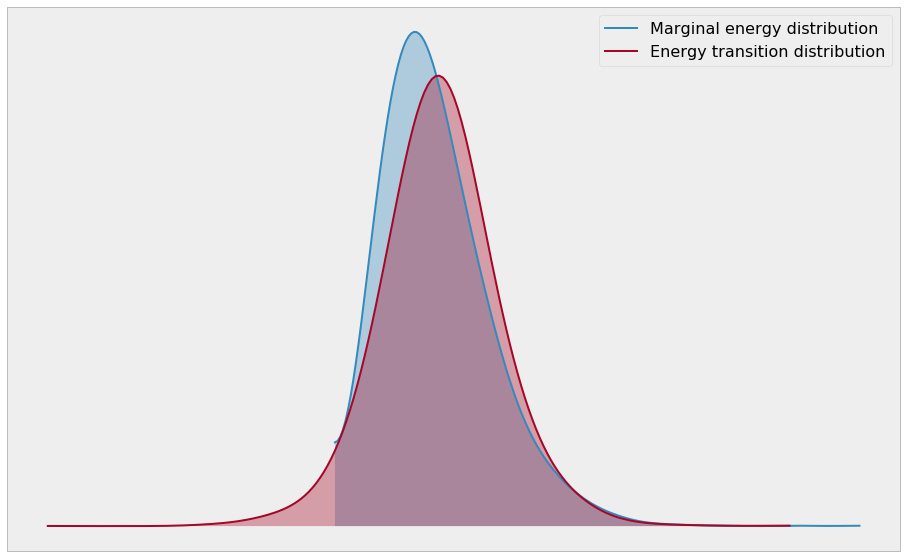

In [63]:
from pymc3 import energyplot

energyplot(trace, figsize = (16,10))

### Contoh fitting (dari Jake VanderPlas) dengan PyMC3

Pertama, re-import semua yang diperlukan (step ini hanya untuk kelengkapan algoritma saja, karena step ini sudah dilakukan di awal notebook ini.

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.visualization import astropy_mpl_style # plot yang lebih bagus
plt.style.use(astropy_mpl_style)

plt.rcParams['figure.figsize'] = (16,10) # ukuran gambar diperbesar
plt.rcParams['font.size'] = 16

Kita akan coba fitting fungsi garis lurus $ y = a + mx$, dengan $a$ adalah nilai *intercept*, dan $m$ adalah *slope* dari garis ini. Fungsi yang akan di-fit adalah $$ y = 25 + 0.5 x$$

In [73]:
# Definisikan suatu fungsi pembuat data
def make_data(intercept, slope, N=75, dy=5, rseed=50):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N) # x-axis data are not equally spaced
    
    y = intercept + slope * x # fungsi garis lurus yang akan difit nantinya
    
    y += dy * rand.randn(N) # generate error for every y-axis datapoint
    
    return x, y, dy * np.ones_like(x)

theta_true = (25, 0.5)
x, y, dy = make_data(*theta_true)

data = dict(x=x, y=y) # buat dictionary yg berisi x,y

numpy.ndarray

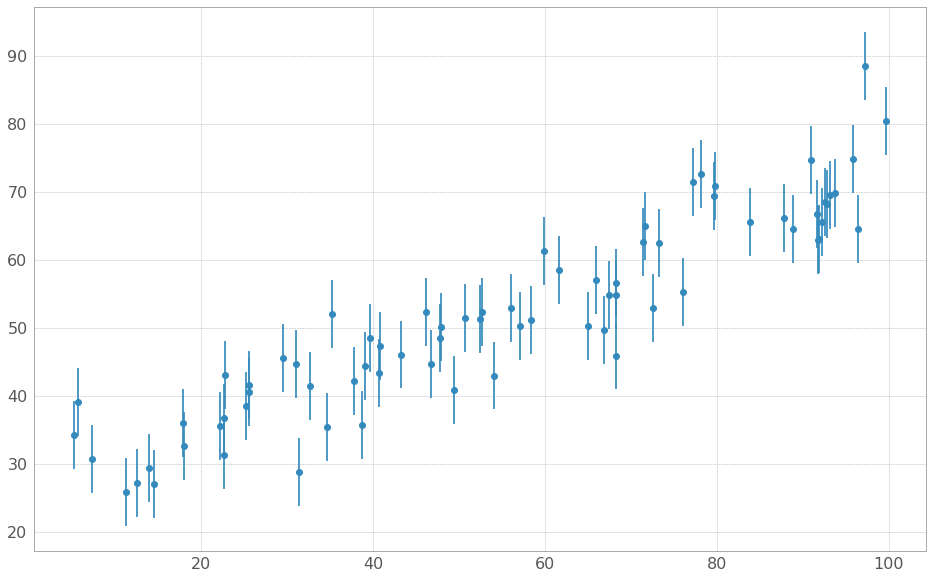

In [66]:
# plot the data
plt.errorbar(x, y, dy, fmt='o')

type(x)

#### Definisikan model

In [67]:
from pymc3 import Model, Normal, HalfNormal, Uniform

# context manager syntax
with Model() as basic_model:
    # prior for unknown
    intercept = Normal('intercept', mu = 0., sd = 10.)
#     intercept = Uniform('intercept', 0, 1)
    slope = Normal('slope', mu = 0., sd = 10.)
    dy = HalfNormal('error', sd = 1.)
    
    # expected values of outcome
    mu = intercept + slope*x
    
    # likelihood of observations
    y_obs = Normal('y_obs', mu = mu, sd = dy, observed = y)

#### Metode MAP untuk mencari perkiraan nilai parameter

In [68]:
from pymc3 import find_MAP # menggunakan algoritma optimisasi BFGS (Broyden-Fletcher-Goldfarb-Shanno)

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

logp = -256.53, ||grad|| = 0.015953: 100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 2616.82it/s]


{'intercept': array(25.227232), 'slope': array(0.48203457), 'error_log__': array(1.56508554), 'error': array(4.78308408)}


#### Percobaan *sampling* dengan NUTS, Metropolis, dll

* **NUTS**

In [69]:
# NUTS algorithm
from pymc3 import NUTS, sample

with basic_model:
    start = find_MAP(method="L-BFGS-B") # MAP method untuk nilai awal
    
    # instantiate sampler
    step = NUTS(scaling=start)
    
    # draw 2000 posterior samples
    trace = sample(2000, step, start=start, live_plot=True)

logp = -256.53, ||grad|| = 0.015953: 100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 2616.97it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error_log__, slope, intercept]


#### Analisis posterior

In [70]:
from pymc3 import summary
summary(trace, ['intercept','slope','error'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
intercept,25.177516,1.238701,0.027729,22.586327,27.458454,2045.142278,1.000079
slope,0.482837,0.020245,0.000445,0.444287,0.522548,2116.747738,1.000246
error,4.867610,0.319338,0.003310,4.247546,5.496347,10267.293118,0.999763


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026E0D5BD048>,
      dtype=object)

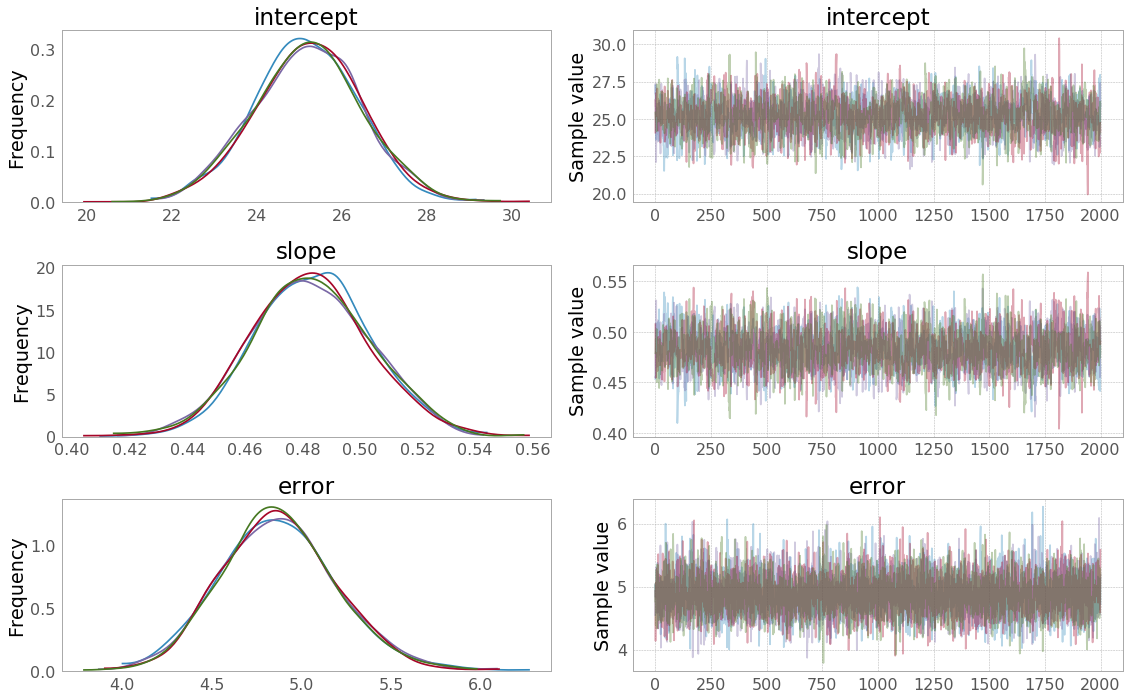

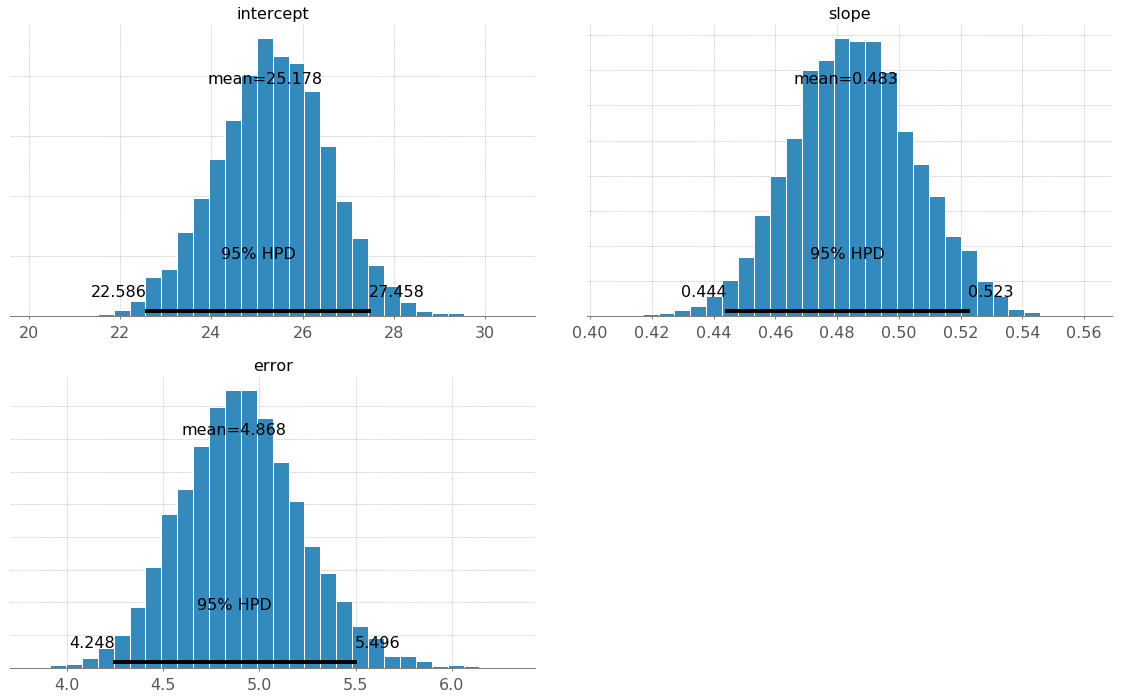

In [71]:
from pymc3 import traceplot
traceplot(trace, figsize = (16,10))

from pymc3 import plot_posterior
plot_posterior(trace, varnames=None, figsize = (16,10))

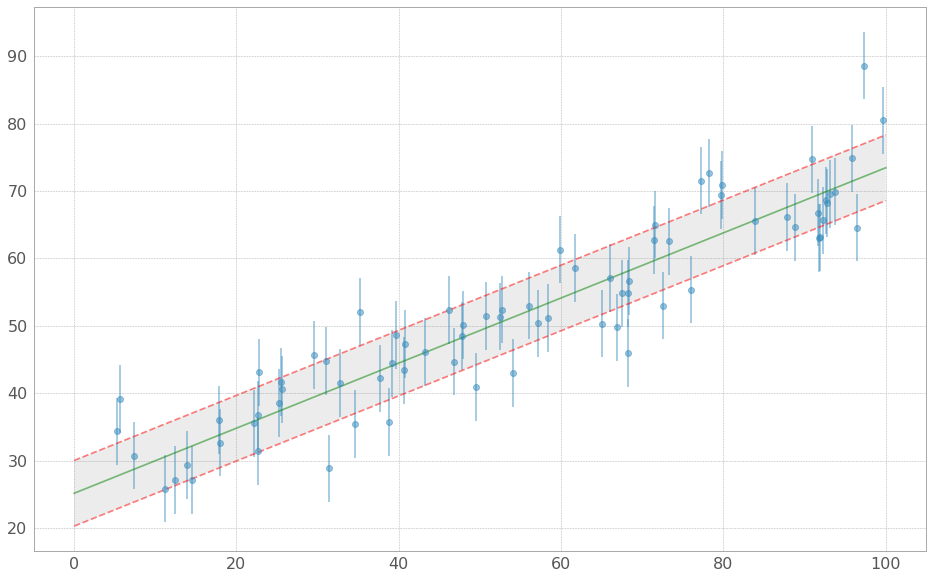

In [74]:
ax = plt.subplot()

xx = np.linspace(0,100,num=8000)

yy = np.mean(trace['intercept']) + np.mean(trace['slope'])*xx

# plt.plot(x, y, 'o')
yy1 = yy - np.mean(trace['error'])
yy2 = yy + np.mean(trace['error'])

plt.errorbar(x, y, dy, fmt='o', alpha=.5)
# plt.plot(x,y,'ok')
ax.plot(xx, yy, '-g', alpha=.5)
ax.plot(xx, yy1, '--r', alpha=0.5)
ax.plot(xx, yy2, '--r', alpha=0.5)
plt.fill_between(xx, yy1, yy2, facecolor="gray", alpha=0.15)

#### Corner plot

In [76]:
import corner
import pandas as pd

data = np.column_stack((trace['intercept'],trace['slope'],trace['error']))

plot = pd.DataFrame(data, columns=['intercept', 'slope', 'error'])

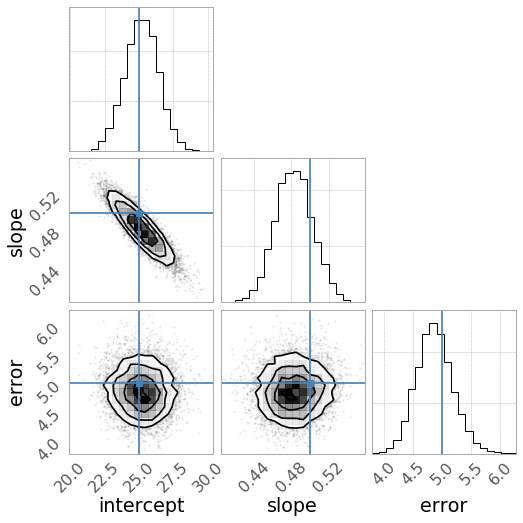

In [77]:
fig = corner.corner(plot, truths=[25., 0.5, 5.])